In [109]:
import urllib.request
import re

#ipnumber = "192.168.0.72"
ipnumber = "192.168.4.1"


In [110]:
url = "http://%s/" % ipnumber
syslog = urllib.request.urlopen(url+"syslog.txt").read()
listdir = urllib.request.urlopen(url).read().decode()
len(syslog), len(listdir)

(1466, 1975)

In [111]:
import pandas

#pandas.TimeDiff #("2017-11-20T19:28:54.547")
dir(pandas)
pandas.to_timedelta
pandas.Timedelta(seconds=1)

Timedelta('0 days 00:00:01')

In [114]:
import pandas

dat = [ ]
for f, s in re.findall("\">(.*)</a></td><td>(\d*)</td>", listdir):
    md = re.match("b?(\d+)_(\d+).dat", f)
    if md:
        syslogd = syslog[int(md.group(1)):].split(b"------", 2)[1].decode()
        mdd = re.search("(\d+) (\d\d\d\d-\d\d-\d\dT\d\d:\d\d:\d\d.\d\d\d)", syslogd)
        toff = pandas.to_datetime(mdd.group(2))
        tf = toff + pandas.Timedelta(seconds=int(md.group(2)))
        dat.append((len(dat), f, tf, s))
dat
                       

[(0, 'b0_82.dat', Timestamp('2017-11-28 20:03:00.854000'), '224'),
 (1, 'b469_2.dat', Timestamp('2017-11-28 20:08:06.762000'), '112'),
 (2, 'b531_2.dat', Timestamp('2017-11-28 20:08:31.359000'), '224'),
 (3, '531_58.dat', Timestamp('2017-11-28 20:09:27.359000'), '0'),
 (4, 'b611_6.dat', Timestamp('2017-11-28 20:09:38.743000'), '28'),
 (5, 'b673_2.dat', Timestamp('2017-11-28 20:33:04.017000'), '1008'),
 (6, '673_109.dat', Timestamp('2017-11-28 20:34:51.017000'), '106552'),
 (7, 'b925_2.dat', Timestamp('2017-11-28 21:48:18.510000'), '1092'),
 (8, 'b987_7.dat', Timestamp('2017-11-29 12:03:20.234000'), '840'),
 (9, '987_109.dat', Timestamp('2017-11-29 12:05:02.234000'), '102144')]

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline


In [115]:
import struct
def loadpd(d):
    db = urllib.request.urlopen(url+d[1]).read()

    vt, vv = [ ], [ ]
    for i in range(8, len(db), 8):
        v = struct.unpack("<II", db[i-8:i])
        vt.append(d[2] + pandas.Timedelta(milliseconds=v[0]))
        vv.append(v[1]/256)
    return pandas.Series(vv, vt)


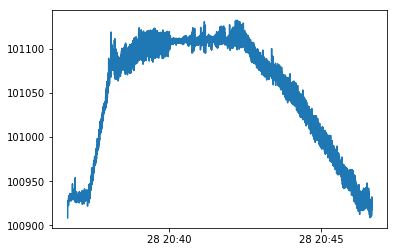

In [116]:
s2 = loadpd(dat[6])
plt.plot(s2)


In [8]:
s1 = loadpd(dat[21])
#s2 = loadpd(dat[-4])



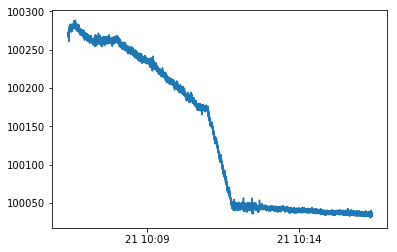

In [78]:
#plt.plot(s1)
plt.plot(s2)


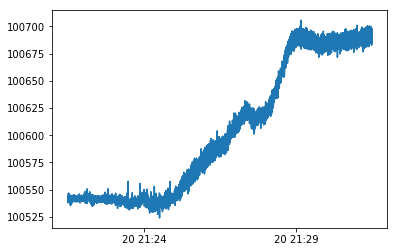

In [15]:
s3 = loadpd(dat[4])
plt.plot(s3)

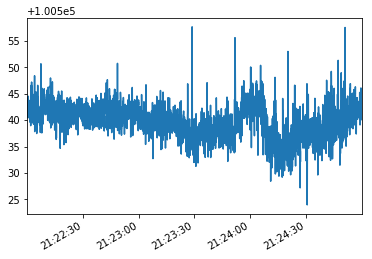

In [28]:
def tss(df, second, minute=None, hour=None):
    t = df.index[0]
    return pandas.Timestamp(year=t.year, month=t.month, day=t.day, 
                            hour=t.hour if hour is None else hour, 
                            minute=t.minute if minute is None else minute,
                            second=second)
    
s3[tss(s3, 0, 22):tss(s3, 0, 25)].plot()



In [120]:
import math

dx0 = 0; dn = 1; dSx = 2; dSx2 = 3; dSy = 4; dSy2 = 5; dSxy = 6; 

# least squares terse functions (done as a list)
# [x0, n, Sx, Sx2, Sy, Sy2, Sxy]
def setpt0(lq, x, y):
    lq[dx0] = x; lq[dn] = 1
    lq[dSx] = 0; lq[dSx2] = 0 
    lq[dSy] = y; lq[dSy2] = y**2; lq[dSxy] = 0

def addpt(lq, x, y):
    x = x - lq[0]
    lq[dn] += 1
    lq[dSx] += x; lq[dSx2] += x**2; 
    lq[dSy] += y; lq[dSy2] += y**2; lq[dSxy] += x*y

def mergelq(lq, llq):
    dx = llq[dx0] - lq[dx0]
    nl = llq[dn]
    lq[dn] += nl
    lq[dSx] += llq[dSx] + nl*dx
    lq[dSx2] += llq[dSx2] + 2*llq[dSx]*dx + nl*dx**2
    lq[dSy] += llq[dSy]
    lq[dSy2] += llq[dSy2]
    lq[dSxy] += llq[dSxy] + llq[dSy]*dx

def copylq(lq, llq):
    for i in range(7):
        lq[i] = llq[i]
    
def calcrsq(lq, m, c):
    rsq = m**2*lq[dSx2] + lq[dn]*c**2 + lq[dSy2] + 2*m*c*lq[dSx] - 2*m*lq[dSxy] - 2*c*lq[dSy]
    return (rsq/lq[dn])

def calcmc(lq):
    m = (lq[dSxy] - lq[dSx]*lq[dSy]/lq[dn])/(lq[dSx2] - lq[dSx]**2/lq[dn])
    c = lq[dSy]/lq[dn] - m*lq[dSx]/lq[dn]
    return m, c

def calcmcL(x0, c0, lqP, lqA):
    cf = (lqA[dSy]*x0**2 + lqP[dSx]*c0*x0 + lqP[dSx2]*c0 - lqP[dSxy]*x0)
    mnum = (lqA[dSx]*cf - lqA[dSxy]*(lqP[dSx2] + lqA[dn]*x0**2))
    cnum = lqA[dSx]*lqA[dSxy]*x0**2 - lqA[dSx2]*cf
    cden = lqA[dSx]**2*x0**2 - lqA[dSx2]*(lqP[dSx2] + lqA[dn]*x0**2)
    return mnum/cden, cnum/cden


In [48]:
100542**2

10108693764

In [79]:
import array

df = s3
t0 = df.index[0]
def lsq(t0, df):
    lq = array.array("f", range(7))
    setpt0(lq, int((df.index[0] - t0)/pandas.Timedelta(milliseconds=1)), int(df.iloc[0]-100000))
    for i in range(1, len(df)):
        addpt(lq, int((df.index[i] - t0)/pandas.Timedelta(milliseconds=1)), int(df.iloc[i]-100000))
    return lq
#df.plot()
#(df.index[10] - df.index[0])/pandas.Timedelta(milliseconds=1)
df.iloc[0]
lq = lsq(t0, df.iloc[20:90])

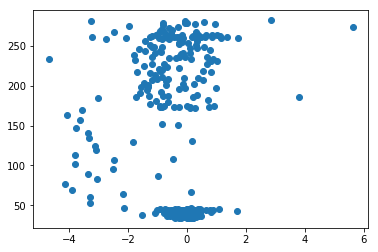

In [88]:
df = s3
df = s2

ys = [ ]
ms = [ ]
rs = [ ]
for i in range(0, len(df), 40):
    lq = lsq(t0, df.iloc[i:i+50])
    m, c = calcmc(lq)
    r = calcr(lq, m, c)
    ms.append(m)
    rs.append(r)
    ys.append(lq[dSy]/lq[dn])
plt.scatter(numpy.array(ms)*1000, ys)

In [87]:
df.index[100] - df.index[0]

Timedelta('0 days 00:00:04.693000')

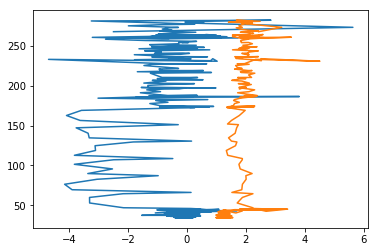

In [89]:
import numpy
plt.plot(numpy.array(ms)*1000, ys)
plt.plot(numpy.array(rs), ys)
#plt.plot(ms, ys)

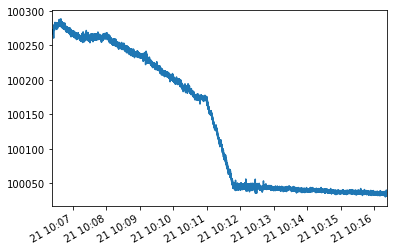

In [84]:
df.plot()

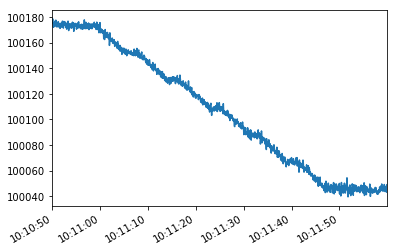

In [86]:
df[tss(df, 50, 10):tss(df, 0, 12)].plot()


In [152]:
df = s3
df = s2

t0 = df.index[0]
print((df.index[-1] - df.index[0])/pandas.Timedelta(seconds=1))


lqR = array.array("f", [0]*7)
lqA = array.array("f", [0]*7)
lqS = array.array("f", [0]*7)
nbatch = 32
rlimsq = 2.2**2
res = [ ]

def nextpt(t, v):
    if lqR[dn] == 0:
        setpt0(lqR, t, v)
        return
    addpt(lqR, t, v)
    if lqR[dn] < nbatch:
        return
    if lqA[dn] == 0:
        copylq(lqA, lqR)
        lqR[dn] = 0
        return
    copylq(lqS, lqA)
    mergelq(lqS, lqR)
    m, c = calcmc(lqS)
    rsq = calcrsq(lqS, m, c)
    if rsq > rlimsq:
        #print("rsq", lqA[dn], rsq)
        res.append(array.array("f", lqA))
        copylq(lqA, lqR)
    else:
        copylq(lqA, lqS)
    lqR[dn] = 0

for i in range(len(df)):
    t = (df.index[i] - t0)/pandas.Timedelta(milliseconds=1)
    v = df.iloc[i]# - 100000
    nextpt(t, v)

print(len(res), len(df)/n)    
#plt.scatter(numpy.array(ms)*1000, ys)


600.362
50 416.1875


In [154]:
#for f in res:
#    print("%f %f %e %e %e %e %e" % tuple(f))

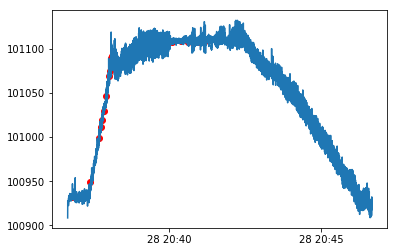

In [156]:
plt.plot(df)
for lq in res:
    plt.scatter([pandas.Timedelta(milliseconds=lq[dSx]/lq[dn] + lq[dx0]) + t0], [lq[dSy]/lq[dn] + 0*100000], color="red")

In [96]:
#plt.plot(rs)
print((df.index[-1] - df.index[0])/pandas.Timedelta(seconds=1))
print(len(df)/600)

600.763
22.248333333333335


In [226]:
# this is the consolidated triple point version

def seqsigma(pv, sigma, sectionlength):
    lqP = [0,0,0,0,0,0,0]    # previous
    c0 = 0
    lqA = [0,0,0,0,0,0,0,0,0,0]  # accumulator (last 3 is m,c,r)
    lqR = [0,0,0,0,0,0,0]
    lqC = [0,0,0,0,0,0,0]

    cs = [ ]
    for t, sv in pv:
        if lqR[dn] == 0:   # first point in segment
            setpt0(lqR, t, v)
            continue
        addpt(lqR, t, v)
        if lqR[dn] < sectionlength:   # segment not complete
            continue
        if lqA[dn] == 0:     # accumulator is empty
            copylq(lqA, lqR)
            lqR[dn] = 0
            continue

        copylq(lqC, lqA)     # make new accumulator value
        mergelq(lqC, lqR)
        if lqP[dn] == 0:     # front accumulator element
            m, c = calcmc(lqC)
            r = calcr(lqC, m, c)
            if r < sigma:    # new accumulator value in tolerance
                copylq(lqA, lqC)
                lqR[dn] = 0
                continue
            m, c = calcmc(lqA)  # go with old accumulator value
            print(calcr(lqA, m, c), m, c)

        else:
            m, c = calcmcL(lqP[dx0] - lqC[dx0], c0, lqP, lqC)
            rp = calcr(lqP, (c - c0)/(-x0), c0)
            r = calcr(lqC, m, c)
            if r < sigma:    # new accumulator value in tolerance
                copylq(lqA, lqC)
                lqR[dn] = 0
                continue
            m, c = calcmcL(lqP[dx0] - lqA[dx0], c0, lqP, lqA)

        cs.append((lqA[dx0], c))
        copylq(lqP, lqA)
        c0 = c
        lqA[dn] = 0
    cs.append((t, c + m*(t - lqA[dx0])))
    return cs


1.9897716182038303 -2.38935919216e-05 100542.339268


(60, 13338)

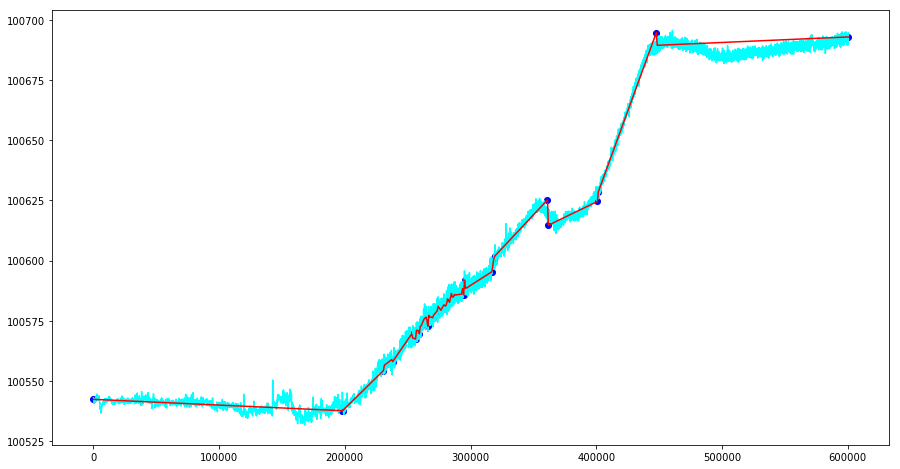

In [240]:
s = s3
pvv = list(zip(((s.index - s.index[0]).values/1e6).tolist(), s))
pv = [pvv[0]]
eps = 0.25
for t, v in pvv:
    pv.append((t, v*eps + pv[-1][1]*(1-eps)))
cs = seqsigma(pv, 2.0, 16)

plt.figure(figsize=(15,8))
plt.plot(*zip(*pv), color="cyan")
plt.plot(*zip(*cs[:]), color="red")
plt.scatter(*zip(*cs[:]), color="blue")

len(cs), len(pv)


2.5085599377


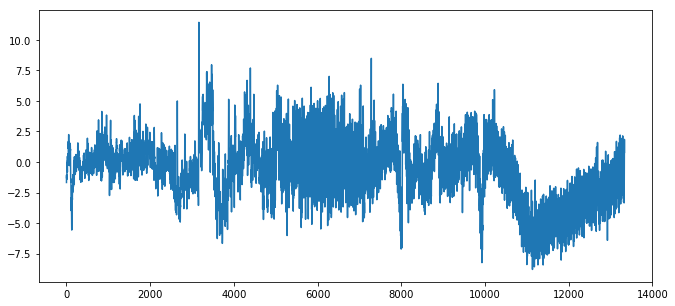

In [241]:
import numpy
def getcx(t):
    for i in range(len(cs)-1):
        if cs[i+1][0]>t:
            break
    lam = (t - cs[i][0])/(cs[i+1][0] - cs[i][0])
    return cs[i][1]*(1-lam) + cs[i+1][1]*lam

dds = [ ]
for t, v in pv[5:]:
    if t < cs[-1][0]:
        dds.append(v - getcx(t))
plt.figure(figsize=(11,5))
plt.plot(dds)
print(numpy.std(dds))

In [324]:
lqC = [0,0,0,0,0,0,0]

def seqsigmaSingle(pv, sigma, sectionlength):
    lqA = [0,0,0,0,0,0,0,0,0,0]  # accumulator (last 3 is m,c,r)
    lqR = [0,0,0,0,0,0,0]
    #lqC = [0,0,0,0,0,0,0]

    v0 = pv[0][1]
    cs = [ ]
    for t, v in pv:
        if lqR[dn] == 0:   # first point in segment
            setpt0(lqR, t, v - v0)
            continue
        addpt(lqR, t, v - v0)
        if lqR[dn] < sectionlength:   # segment not complete
            continue
        if lqA[dn] == 0:     # accumulator is empty
            copylq(lqA, lqR)
            lqR[dn] = 0
            continue
        copylq(lqC, lqA)     # make new accumulator value
        mergelq(lqC, lqR)
        
        m, c = calcmc(lqC)
        r = calcr(lqC, m, c)
        if r < sigma:    # new accumulator value in tolerance
            copylq(lqA, lqC)
            lqR[dn] = 0
            continue
        m, c = calcmc(lqA)  # go with old accumulator value
        cs.append((lqA[0], m, c + v0))
        copylq(lqA, lqR)
        lqR[dn] = 0
    cs.append((lqA[0], m, c + v0))
    return cs


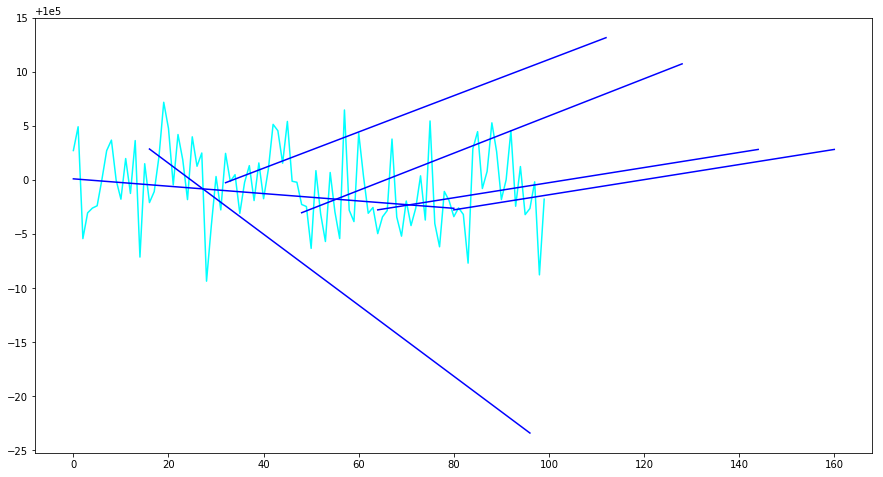

In [325]:
import random
pv = [ (i, random.gauss(100000 + i*0, sigma))  for i in range(100) ]
cs = seqsigmaSingle(pv, 0.2, 16)
plt.figure(figsize=(15,8))
plt.plot(*zip(*pv), color="cyan")
for l in cs:
    plt.plot((l[0], l[0]+80), (l[2], l[2] + 80*l[1]), color="blue")


In [297]:
pv[0]

(0, 100542.96875)

In [280]:
-lq[dSx]/lq[dn]

-20602.884868421053

In [300]:
lq = lqC
print(lq)
m = (lq[dSxy] - lq[dSx]*lq[dSy]/lq[dn])/(lq[dSx2] - lq[dSx]**2/lq[dn])
c = lq[dSy]/lq[dn] - m*lq[dSx]/lq[dn]

print("mm", lq[dSy]/lq[dn], -lq[dSx]/lq[dn])
print(m, c)
#r = calcr(lqC, m, c)

rsq = m**2*lq[dSx2] + lq[dSy2] - 2*m*lq[dSxy] + c*(lq[dn]*c + 2*m*lq[dSx] - 2*lq[dSy])


print("rr", m**2*lq[dSx2] + lq[dSy2] - 2*m*lq[dSxy], c*(lq[dn]*c + 2*m*lq[dSx] - 2*lq[dSy]))
rsq = m**2*lq[dSx2] + lq[dn]*c**2 + lq[dSy2] + 2*m*c*lq[dSx] - 2*m*lq[dSxy] - 2*c*lq[dSy]
print(rsq)
print(m**2*lq[dSx2], lq[dn]*c**2, lq[dSy2], 2*m*c*lq[dSx], - 2*m*lq[dSxy], - 2*c*lq[dSy])
print(rsq)
r = math.sqrt(rsq/lq[dn])


[0, 9168, 1892583518, 520876904765622, 1318258.125, 189551099.92675781, 272132809756.17188]
mm 143.7890625 -206433.6297993019
-2.3441877317e-19 143.7890625
rr 189551099.927 -189551099.927
-5.96046447754e-08
2.86233116436e-23 189551099.927 189551099.927 -1.27586078805e-07 1.27586078805e-07 -379102199.854
-5.96046447754e-08


ValueError: math domain error

(48, 13338)

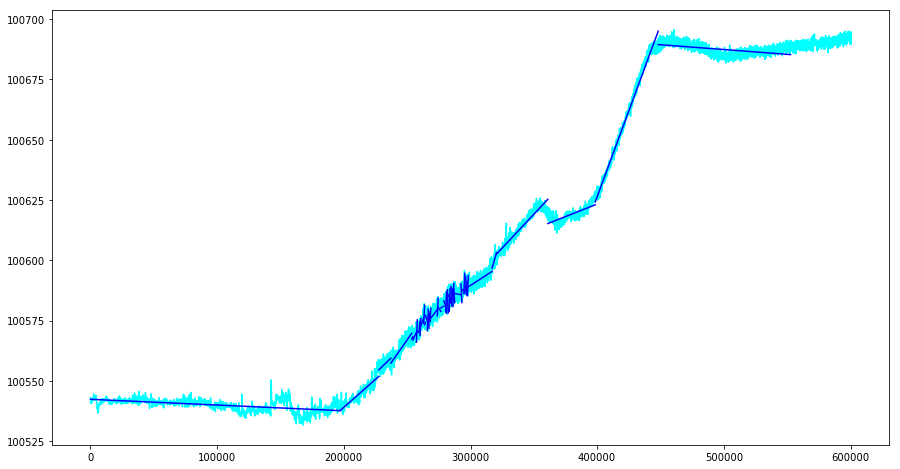

In [331]:
s = s3
pvv = list(zip(((s.index - s.index[0]).values/1e6).tolist(), s))
pv = [pvv[0]]
eps = 0.25
for t, v in pvv:
    pv.append((t, v*eps + pv[-1][1]*(1-eps)))
cs = seqsigmaSingle(pv, 2.0, 16)

plt.figure(figsize=(15,8))
plt.plot(*zip(*pv), color="cyan")
for i in range(len(cs)-1):
    l = cs[i]
    ex = cs[i+1][0] - cs[i][0]
    plt.plot((l[0], l[0]+ex), (l[2], l[2] + ex*l[1]), color="blue")

len(cs), len(pv)

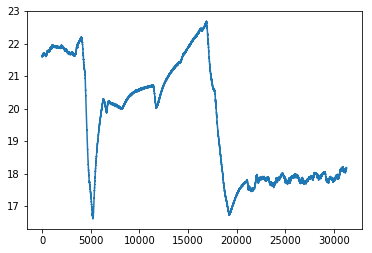

In [5]:
# here we get the algorithms finalized and in a state 
# to move back to the device

# needs to cut down on memory; simplify the equations
# double-check the range of standard deviation

from matplotlib import pyplot as plt
%matplotlib inline

import pandas
pv = pandas.read_csv("temps2.csv")
pv.v = pv.v/100

pv["t"] = list(range(len(pv.v)))

pv = list(zip(pv.t, pv.v))
plt.plot(*zip(*pv))


In [113]:
((s3.index[:3] - s3.index[0]).values/1e6).tolist()


[0, 161, 326]

In [116]:
pv = list(zip(((s3.index - s3.index[0]).values/1e6).tolist(), s3))
pv;


In [126]:
# least squares accumulating into buffers and outputting
# into thinned pieces

lqA = [0,0,0,0,0,0,0,0,0,0]  # accumulator (last 3 is m,c,r)
lqR = [0,0,0,0,0,0,0]
lqC = [0,0,0,0,0,0,0]

sigma = 4.5
sectionlength = 16
bcopyrtoa = False

def processpt(t, v):
    global bcopyrtoa
    if bcopyrtoa:  # deferred
        copylq(lqA, lqR)
        lqA[7], lqA[8], lqA[9] = calcmc(lqA)
        lqR[dn] = 0
        bcopyrtoa = False
        
    if lqR[dn] == 0:
        setpt0(lqR, t, v)
        return False
    addpt(lqR, t, v)
    if lqR[dn] < sectionlength:
        return False
    if lqA[dn] == 0:
        copylq(lqA, lqR)
        lqR[dn] = 0
        return False
    
    copylq(lqC, lqA)
    mergelq(lqC, lqR)
    m, c, r = calcmc(lqC)
    if r < sigma:
        copylq(lqA, lqC)
        lqA[7] = m
        lqA[8] = c
        lqA[9] = r
        lqR[dn] = 0
        return False
    bcopyrtoa = True  # defer
    return True




In [166]:
s = s1
pv = list(zip(((s.index - s.index[0]).values/1e6).tolist(), s))
pv;

lqA = [0,0,0,0,0,0,0,0,0,0]  # accumulator (last 3 is m,c,r)
lqR = [0,0,0,0,0,0,0]
lqC = [0,0,0,0,0,0,0]

sigma = 2.5
sectionlength = 16
bcopyrtoa = False


cs = [ ]
for t, v in pv:
    if processpt(t, v):
        if lqP[dn] != 0:
            x0 = lqP[dx0] - lqA[dx0]
            c = calcc(x0, c0, lqP, lqA)
        else:
            c = lqA[8]
        cs.append((lqA[dx0], c))
        copylq(lqP, lqA)
        c0 = c


In [207]:
len(cs)

369

(230, 31320)

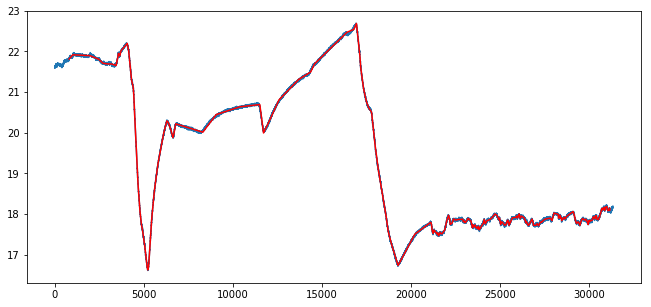

In [55]:
plt.figure(figsize=(11,5))
plt.plot(*zip(*pv))
plt.plot(*zip(*cs[5:]), color="red")
len(cs), len(pv)

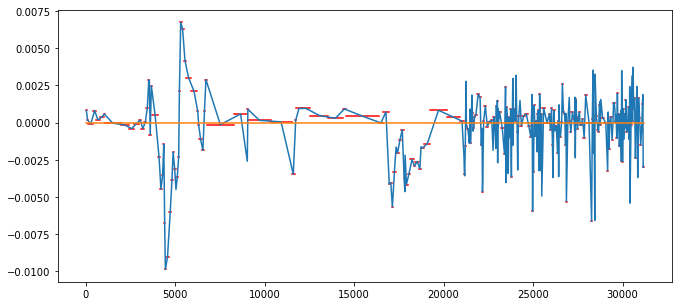

In [23]:
plt.figure(figsize=(11,5))
for (t, v), (t1, v1) in zip(cs, cs[1:]):
    s = (v1-v)/(t1-t)
    plt.plot([t, t1], [s, s], color="red")
plt.plot(*zip(*[((t+t1)/2, (v1-v)/(t1-t))  for (t, v), (t1, v1) in zip(cs, cs[1:]) ]))
#plt.plot(*zip(*vv))
plt.plot([0,cs[-1][0]], [0,0])